In [59]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import scipy.stats as st
import seaborn as sns

In [31]:
# function to set timestamp on output file
def get_dt():
    dt_stamp = dt.datetime.now()
    dt_stamp = dt_stamp.strftime("%Y_%m_%d_%H%M%S")
    dt_stamp = str(dt_stamp).split(".")[0]
    return dt_stamp

In [32]:
# Define a function to create Linear Regression plots
def lin_reg(x, y):
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), 'r')

In [33]:
# Import Cancer data
incident_data = pd.read_csv('C:/C_Drive/Bootcamp/Homework/Project-One-1/U.S._Chronic_Disease_Indicators__Cancer_Final.csv')

In [34]:
# Import unemployment rates and total population
employment_data = pd.read_csv('C:/C_Drive/Bootcamp/ProjectData/Unemployment_2015_2019_final.csv')

In [35]:
# Import median household income
income_data = pd.read_csv('C:/C_Drive/Bootcamp/ProjectData/median_house_income.csv')

In [36]:
# Limit data:
#        Race = White, Black, Hispanic
#        Year >= 2015
df_inc = incident_data.loc[(incident_data['StratificationCategory1'] == 'Race')
                   & (incident_data['Year'] >= 2015)
                    & (incident_data['DataValueType'] == 'Average Annual Number')
                    & ((incident_data['Stratification1'] == 'Black')
                    | (incident_data['Stratification1'] == 'Hispanic')
                    | (incident_data['Stratification1'] == 'White'))].copy()

In [37]:
df_inc.head()

,Year,LocationAbbr,LocationDesc,Topic,Question,DataValueType,DataValue,StratificationCategory1,Stratification1
4,2017,AL,Alabama,Breast Cancer,incidence,Average Annual Number,31,Race,Hispanic
5,2016,AR,Arkansas,Breast Cancer,incidence,Average Annual Number,46,Race,Hispanic
14,2018,FL,Florida,Breast Cancer,incidence,Average Annual Number,2953,Race,Hispanic
17,2015,GA,Georgia,Breast Cancer,incidence,Average Annual Number,204,Race,Hispanic
18,2018,GA,Georgia,Breast Cancer,incidence,Average Annual Number,272,Race,Hispanic


In [38]:
# Limit data:
#        States to exclude due to missing data
#        Metrics are incident and mortality average incidents

# Create flag to isolate rows to delete
df_inc['flag'] = df_inc.loc[(df_inc['LocationDesc'] == 'Idaho')
                                | (df_inc['LocationDesc'] == 'Illinois')
                                | (df_inc['LocationDesc'] == 'Kansas')
                                | (df_inc['LocationDesc'] == 'Massachusetts')
                                | (df_inc['LocationDesc'] == 'Montana')
                                | (df_inc['LocationDesc'] == 'North Dakota')
                                | (df_inc['LocationDesc'] == 'South Dakota')
                                | (df_inc['LocationDesc'] == 'Vermont')
                                | (df_inc['LocationDesc'] == 'Washington, D.C.')
                                | (df_inc['LocationDesc'] == 'Wyoming')
                                | (df_inc['LocationDesc'] == 'District of Columbia')
                                | (df_inc['LocationDesc'] == 'Maine')
                                | (df_inc['LocationDesc'] == 'West Virginia')
                                , 'LocationAbbr']

# Delete rows
df_inc = df_inc.loc[df_inc['flag'].isna()]

# Drop flag column
df_inc.drop('flag',axis=1, inplace=True)

In [39]:
# Clean:
#   Rename columns
#   Group data to exclude unneeded columns and metrics
df_inc.rename(columns={'LocationDesc': 'State', 'Stratification1': 'Race'}, inplace=True)
df_inc_gb = df_inc.groupby(['Year', 'State', 'Question', 'Race'], as_index=False)['DataValue'].mean()

df_inc_gb.head()

,Year,State,Question,Race,DataValue
0,2015,Alabama,incidence,Black,886.0
1,2015,Alabama,incidence,Hispanic,30.0
2,2015,Alabama,incidence,White,2689.0
3,2015,Alabama,mortality,Black,200.0
4,2015,Alabama,mortality,White,472.0


In [40]:
# income_data.rename(columns={'state': 'State'}, inplace=True)
income_data.head()

,State,Year,Household_Income
0,United States,2019,65712
1,"Washington, D.C.",2019,92266
2,Maryland,2019,86738
3,Massachusetts,2019,85843
4,New Jersey,2019,85751


In [41]:
# Merge incident data with income data
df_merge1 = pd.merge(df_inc_gb, income_data, on=['State', 'Year'], how='left')

In [42]:
# Rename columns to join on index label
employment_data.rename(columns={'state': 'State', 'unemployed_rate': 'unemployment_rate'}, inplace=True)

In [43]:
# Merge incident data with employment data
df_merge2 = pd.merge(df_merge1, employment_data, on=['State', 'Year'], how='left')

In [44]:
df_merge2.head()

,Year,State,Question,Race,DataValue,Household_Income,total_population,total_labor_force,tlf_percent_population,total_employed,emp_percent_population,total_unemployed,unemployment_rate
0,2015,Alabama,incidence,Black,886.0,44765,3807670.0,2133700.0,56.0,2003525.0,52.6,130175.0,6.1
1,2015,Alabama,incidence,Hispanic,30.0,44765,3807670.0,2133700.0,56.0,2003525.0,52.6,130175.0,6.1
2,2015,Alabama,incidence,White,2689.0,44765,3807670.0,2133700.0,56.0,2003525.0,52.6,130175.0,6.1
3,2015,Alabama,mortality,Black,200.0,44765,3807670.0,2133700.0,56.0,2003525.0,52.6,130175.0,6.1
4,2015,Alabama,mortality,White,472.0,44765,3807670.0,2133700.0,56.0,2003525.0,52.6,130175.0,6.1


In [45]:
# Exclude rows with NaN. State = United States.
df_merge3 = df_merge2.loc[(~df_merge2['unemployment_rate'].isna())].copy()

In [46]:
# Unstack Incidence and Mortality
df_merge3['incidence'] = df_merge3.loc[df_merge3['Question'] == 'incidence', 'DataValue']
df_merge3['mortality'] = df_merge3.loc[df_merge3['Question'] == 'mortality', 'DataValue']
df_clean = df_merge3.groupby(['Year', 'State', 'Race', 'Household_Income', 'total_population', 'total_labor_force', 'total_unemployed',
                               'unemployment_rate'], as_index=False).agg({'incidence': 'sum', 'mortality': 'sum'})
df_clean['unemployed (000)'] = df_clean['total_unemployed'] / 100
df_clean.head()

,Year,State,Race,Household_Income,total_population,total_labor_force,total_unemployed,unemployment_rate,incidence,mortality,unemployed (000)
0,2015,Alabama,Black,44765,3807670.0,2133700.0,130175.0,6.1,886.0,200.0,1301.75
1,2015,Alabama,Hispanic,44765,3807670.0,2133700.0,130175.0,6.1,30.0,0.0,1301.75
2,2015,Alabama,White,44765,3807670.0,2133700.0,130175.0,6.1,2689.0,472.0,1301.75
3,2015,Alaska,Black,73355,544288.0,361660.0,23088.0,6.4,12.0,0.0,230.88
4,2015,Alaska,Hispanic,73355,544288.0,361660.0,23088.0,6.4,13.0,0.0,230.88


In [47]:
# Create Race Dataframe as iterator for loop
df_race = df_clean.groupby('Race', as_index=False)['Race'].first()
df_race.head()


,Race
0,Black
1,Hispanic
2,White


In [48]:
# Create summary table by race to show mix % by year
df2_gb = df_clean.groupby(['Year', 'Race'], as_index=False)['incidence'].sum()
df2_gb.sort_values(['Year', 'incidence'], ascending=[True, False])

df_summ = df2_gb.groupby(['Year', 'Race'])['incidence'].sum().unstack().fillna(0)
df_summ = df_summ[['White', 'Black', 'Hispanic']]
df_summ

Race,White,Black,Hispanic
Year,,,
2015,158471.0,24824.0,17757.0
2016,160633.0,25454.0,18604.0
2017,162824.0,26056.0,19523.0
2018,164746.0,26497.0,20330.0
2019,166668.0,27023.0,21320.0


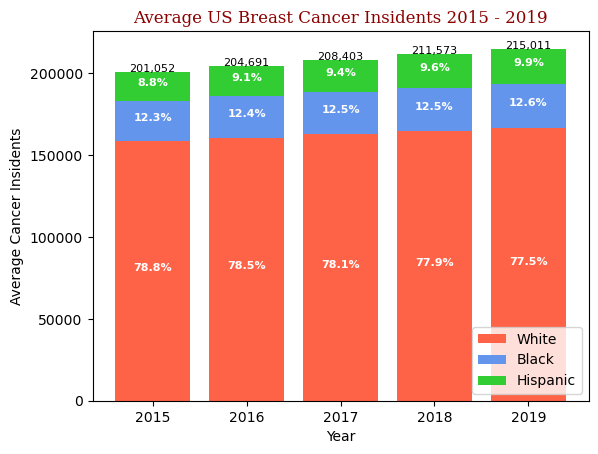

In [49]:
# Plot mix % of race by year

font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig, ax = plt.subplots()

colors = ['tomato', 'cornflowerblue', 'limegreen']
bottom = np.zeros(len(df_summ))

for i, col in enumerate(df_summ.columns):
    ax.bar(df_summ.index, df_summ[col], bottom=bottom, label=col, color=colors[i])
    bottom += np.array(df_summ[col])

totals = df_summ.sum(axis=1)
y_offset = 50

for i, total in enumerate(totals):
    ax.text(totals.index[i], total + y_offset, f'{round(total):,.0f}', ha='center', size=8)

# Add percentages as labels
for idx in df_summ.index:
    start = 0
    for col in df_summ.columns:
        y = df_summ.loc[idx, col]
        value = df_summ.loc[idx, col]
        total = df_summ.loc[idx, :].sum()
        ax.text(
            x=idx,
            y=start + y / 2,
            s=f"{round(100 * value / total, 1)}%",
            fontsize=8,
            weight='bold',
            ha="center",
            color="w",
        )
        start += y

ax.set_title('Average US Breast Cancer Insidents 2015 - 2019', fontdict=font)
ax.set_xlabel('Year')
ax.set_ylabel('Average Cancer Insidents')
ax.legend(loc='lower right')
plt.show()

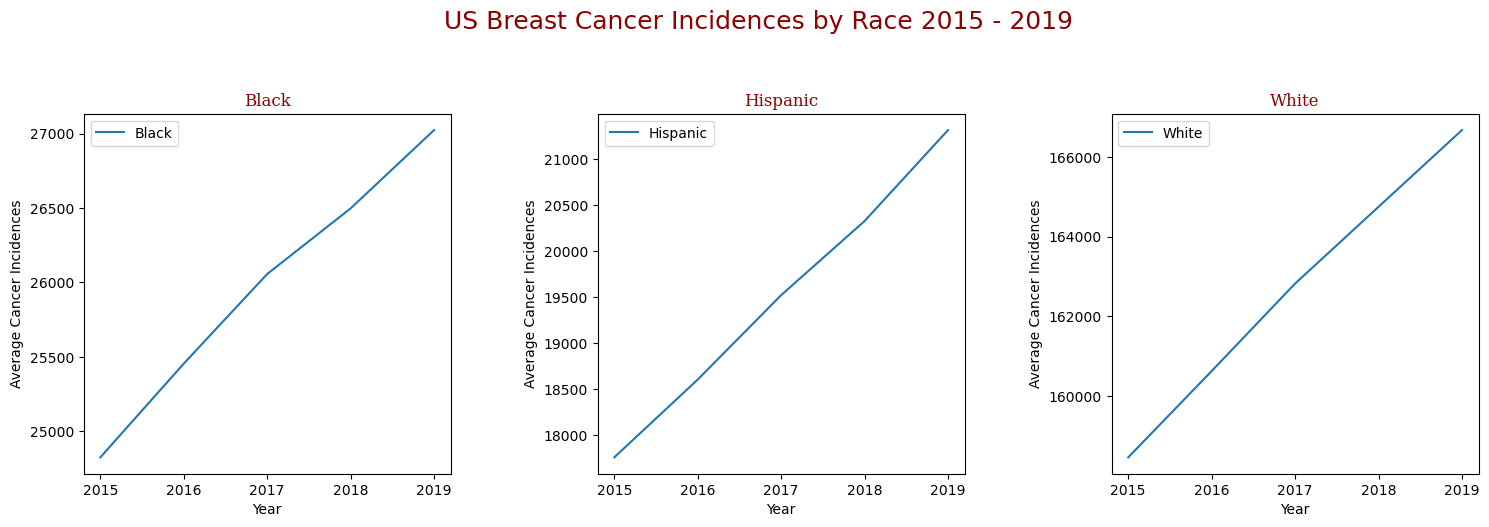

In [50]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure(figsize=(18,8))
fig.subplots_adjust(wspace=.4, top=.85, bottom=.4)
fig.suptitle(f'US Breast Cancer Incidences by Race 2015 - 2019', fontsize=18, ha='center', color='darkred')

for n, race in df_race.iterrows():
    ax = fig.add_subplot(1, 3, n + 1)
    x = df2_gb.loc[(df2_gb['Race'] == race[0]), 'Year'].values.astype(str)
    y = df2_gb.loc[(df2_gb['Race'] == race[0]), 'incidence'].values.astype(int)
    ax.plot(x, y, label=race[0])
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Cancer Incidences')
    ax.legend()
    ax.set_title(f'{race[0]}', fontdict=font)
    # ax.xaxis.set_tick_params(width=5)
    # ax.yaxis.set_tick_params(width=5)
    # fig.tight_layout()

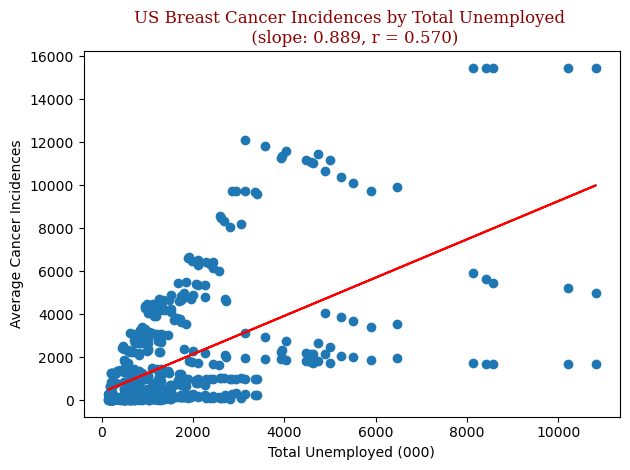

In [51]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure()
fig.subplots_adjust(wspace=.2, top=.85, bottom=.4)
# fig.suptitle(f'US Breast Cancer Incidences by Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

# for n, race in df3.iterrows():
ax = fig.add_subplot()
x = df_clean['unemployed (000)']
y = df_clean['incidence']
ax.scatter(x, y)
lin_reg(np.array(x), np.array(y))
r, p = st.pearsonr(np.array(x), np.array(y))
z = np.polyfit(np.array(x), np.array(y), 1)
ax.set_title(f'US Breast Cancer Incidences by Total Unemployed \n (slope: {z[0]:.3f}, r = {r:.3f})', fontdict=font)
ax.set_xlabel('Total Unemployed (000)')
ax.set_ylabel('Average Cancer Incidences')
fig.tight_layout()
plt.show()

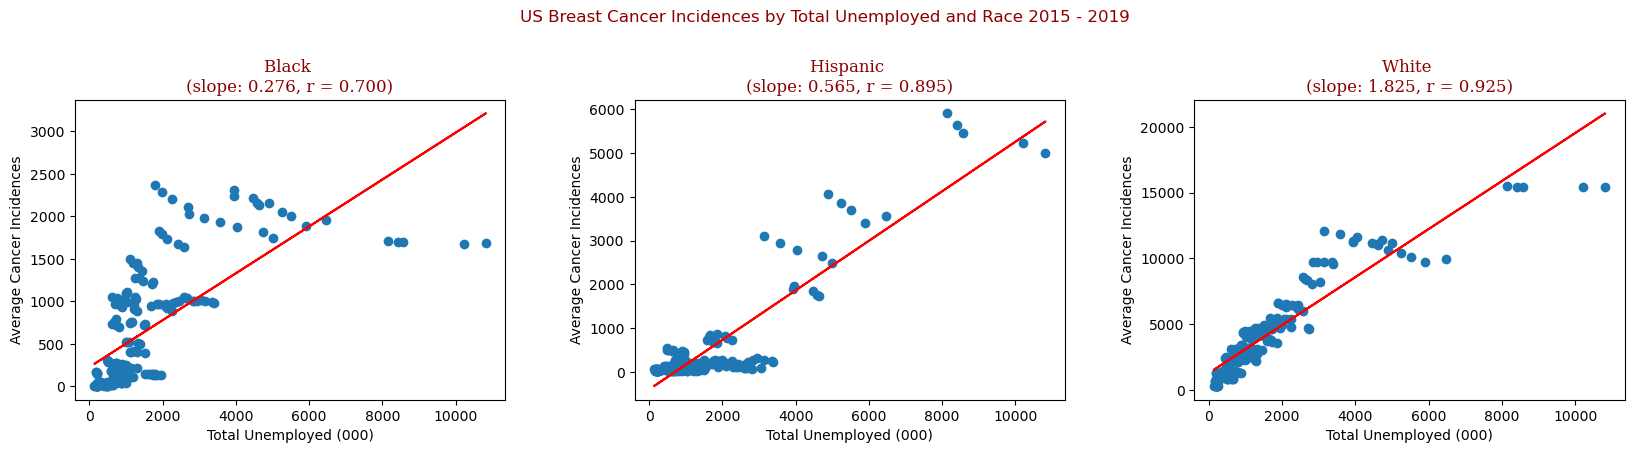

In [52]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=.3, top=.8, bottom=.2)
fig.suptitle(f'US Breast Cancer Incidences by Total Unemployed and Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

for n, race in df_race.iterrows():
    ax = fig.add_subplot(1, 3, n + 1)
    x = df_clean.loc[(df_clean['Race'] == race[0]), 'unemployed (000)'].values
    y = df_clean.loc[(df_clean['Race'] == race[0]), 'incidence'].values
    ax.scatter(x, y)
    lin_reg(np.array(x), np.array(y))
    r, p = st.pearsonr(np.array(x), np.array(y))
    z = np.polyfit(np.array(x), np.array(y), 1)
    ax.set_title(f'{race[0]} \n(slope: {z[0]:.3f}, r = {r:.3f})', fontdict=font)
    ax.set_xlabel('Total Unemployed (000)')
    ax.set_ylabel('Average Cancer Incidences')

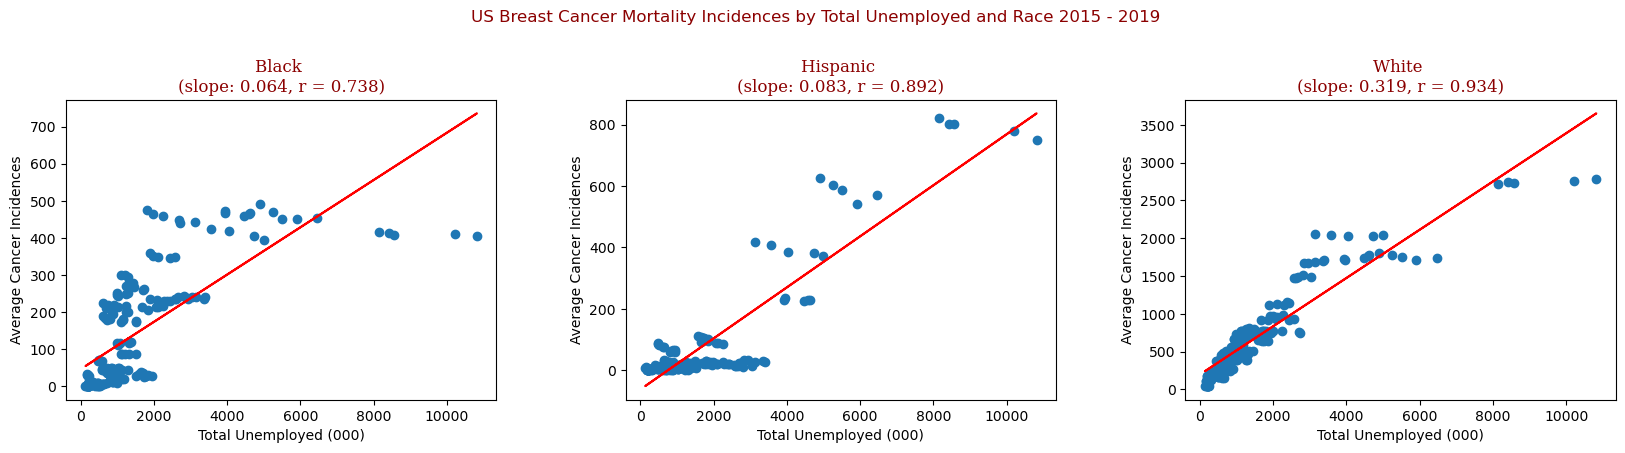

In [53]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=.3, top=.8, bottom=.2)
fig.suptitle(f'US Breast Cancer Mortality Incidences by Total Unemployed and Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

for n, race in df_race.iterrows():
    ax = fig.add_subplot(1, 3, n + 1)
    x = df_clean.loc[(df_clean['Race'] == race[0]), 'unemployed (000)'].values
    y = df_clean.loc[(df_clean['Race'] == race[0]), 'mortality'].values
    ax.scatter(x, y)
    lin_reg(np.array(x), np.array(y))
    r, p = st.pearsonr(np.array(x), np.array(y))
    z = np.polyfit(np.array(x), np.array(y), 1)
    ax.set_title(f'{race[0]} \n(slope: {z[0]:.3f}, r = {r:.3f})', fontdict=font)
    ax.set_xlabel('Total Unemployed (000)')
    ax.set_ylabel('Average Cancer Incidences')

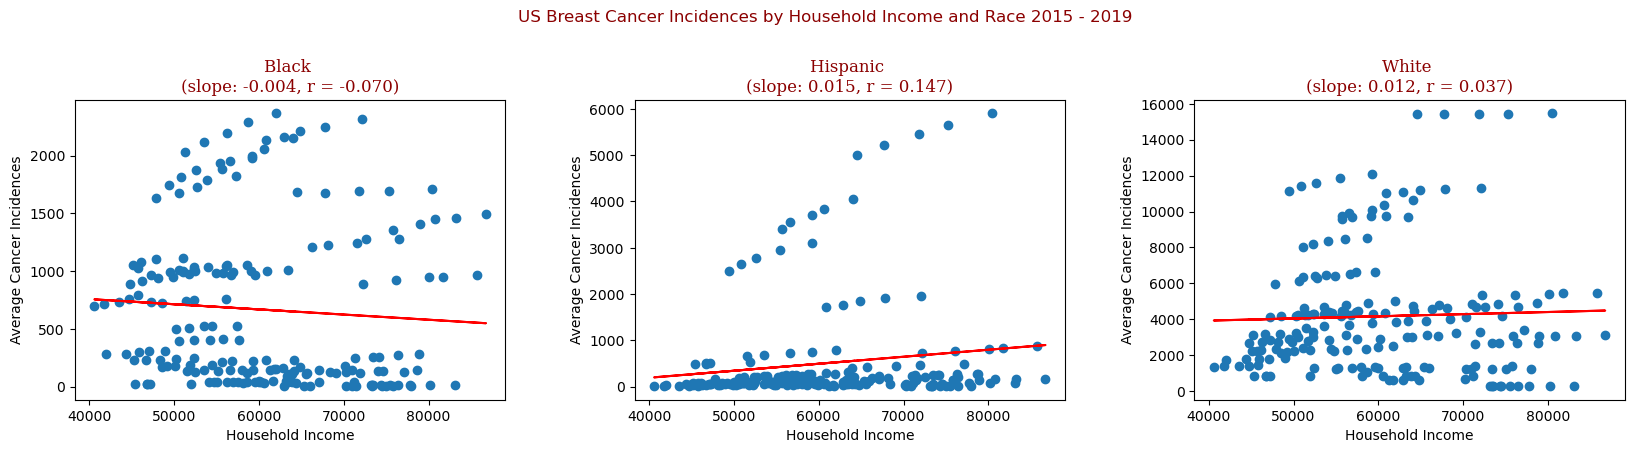

In [54]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=.3, top=.8, bottom=.2)
fig.suptitle(f'US Breast Cancer Incidences by Household Income and Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

for n, race in df_race.iterrows():
    ax = fig.add_subplot(1, 3, n + 1)
    x = df_clean.loc[(df_clean['Race'] == race[0]), 'Household_Income'].values
    y = df_clean.loc[(df_clean['Race'] == race[0]), 'incidence'].values
    ax.scatter(x, y)
    lin_reg(np.array(x), np.array(y))
    r, p = st.pearsonr(np.array(x), np.array(y))
    z = np.polyfit(np.array(x), np.array(y), 1)
    ax.set_title(f'{race[0]} \n(slope: {z[0]:.3f}, r = {r:.3f})', fontdict=font)
    ax.set_xlabel('Household Income')
    ax.set_ylabel('Average Cancer Incidences')

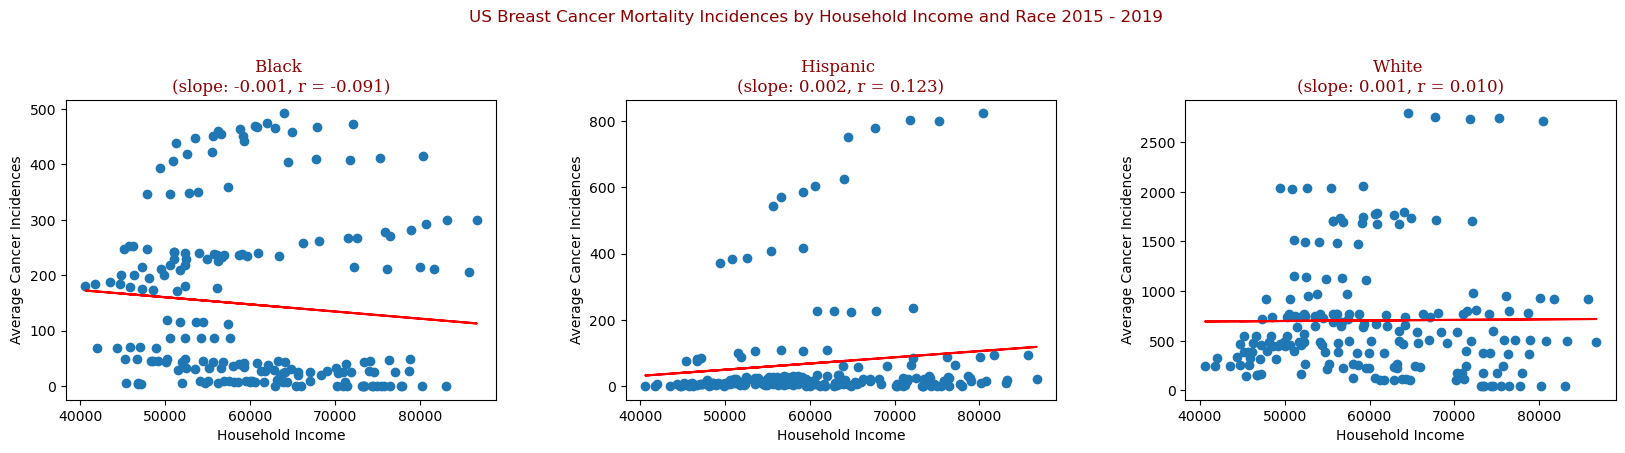

In [55]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=.3, top=.8, bottom=.2)
fig.suptitle(f'US Breast Cancer Mortality Incidences by Household Income and Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

for n, race in df_race.iterrows():
    ax = fig.add_subplot(1, 3, n + 1)
    x = df_clean.loc[(df_clean['Race'] == race[0]), 'Household_Income'].values
    y = df_clean.loc[(df_clean['Race'] == race[0]), 'mortality'].values
    ax.scatter(x, y)
    lin_reg(np.array(x), np.array(y))
    r, p = st.pearsonr(np.array(x), np.array(y))
    z = np.polyfit(np.array(x), np.array(y), 1)
    ax.set_title(f'{race[0]} \n(slope: {z[0]:.3f}, r = {r:.3f})', fontdict=font)
    ax.set_xlabel('Household Income')
    ax.set_ylabel('Average Cancer Incidences')

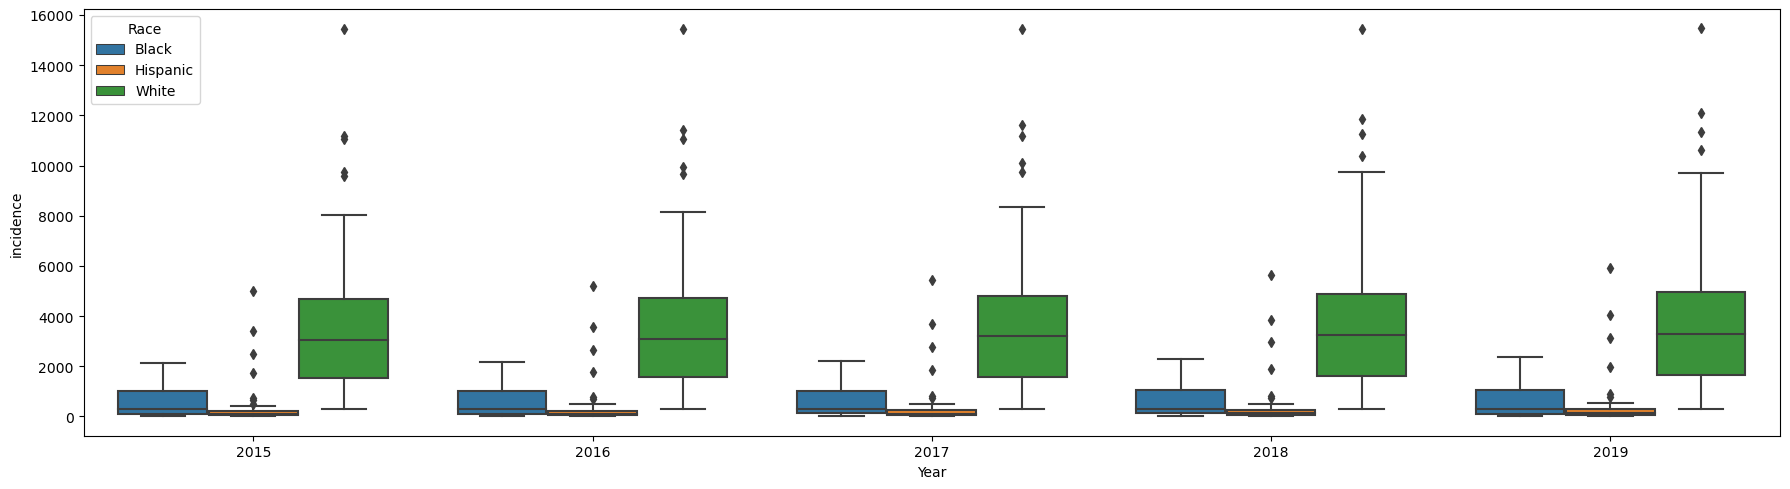

In [65]:
# Set the figure size
plt.rcParams["figure.figsize"] = [18.00, 5.0]
plt.rcParams["figure.autolayout"] = True

# Create a grouped boxplot
sns.boxplot(x=df_clean['Year'], y=df_clean['incidence'], hue=df_clean['Race'])
plt.show()

In [109]:
dfb = df_clean.loc[df_clean['Race'] == 'Black'].copy()
dfb['zScore'] = np.abs(st.zscore(dfb['incidence']))
dfb = dfb.loc[dfb['zScore'] <= 3]
dfb.head()

,Year,State,Race,Household_Income,total_population,total_labor_force,total_unemployed,unemployment_rate,incidence,mortality,unemployed (000),zScore
0,2015,Alabama,Black,44765,3807670.0,2133700.0,130175.0,6.1,886.0,200.0,1301.75,0.320937
3,2015,Alaska,Black,73355,544288.0,361660.0,23088.0,6.4,12.0,0.0,230.88,0.953583
6,2015,Arizona,Black,51492,5325671.0,3212709.0,185261.0,5.8,137.0,29.0,1852.61,0.771300
9,2015,Arkansas,Black,41995,2305251.0,1343071.0,57606.0,4.3,279.0,69.0,576.06,0.564227
12,2015,California,Black,64500,30422273.0,18886247.0,1082097.0,5.7,1685.0,405.0,10820.97,1.486087


In [110]:
dfh = df_clean.loc[df_clean['Race'] == 'Hispanic'].copy()
dfh['zScore'] = np.abs(st.zscore(dfh['incidence']))
dfh = dfh.loc[dfh['zScore'] <= 3]
dfh.head()

,Year,State,Race,Household_Income,total_population,total_labor_force,total_unemployed,unemployment_rate,incidence,mortality,unemployed (000),zScore
1,2015,Alabama,Hispanic,44765,3807670.0,2133700.0,130175.0,6.1,30.0,0.0,1301.75,0.427221
4,2015,Alaska,Hispanic,73355,544288.0,361660.0,23088.0,6.4,13.0,0.0,230.88,0.442668
7,2015,Arizona,Hispanic,51492,5325671.0,3212709.0,185261.0,5.8,653.0,100.0,1852.61,0.138864
10,2015,Arkansas,Hispanic,41995,2305251.0,1343071.0,57606.0,4.3,42.0,5.0,576.06,0.416317
16,2015,Colorado,Hispanic,63909,4275910.0,2853704.0,95069.0,3.3,404.0,60.0,950.69,0.087388


In [111]:
dfw = df_clean.loc[df_clean['Race'] == 'White'].copy()
dfw['zScore'] = np.abs(st.zscore(dfw['incidence']))
dfw = dfw.loc[dfw['zScore'] <= 3]
dfw.head()

,Year,State,Race,Household_Income,total_population,total_labor_force,total_unemployed,unemployment_rate,incidence,mortality,unemployed (000),zScore
2,2015,Alabama,White,44765,3807670.0,2133700.0,130175.0,6.1,2689.0,472.0,1301.75,0.430882
5,2015,Alaska,White,73355,544288.0,361660.0,23088.0,6.4,308.0,45.0,230.88,1.123151
8,2015,Arizona,White,51492,5325671.0,3212709.0,185261.0,5.8,3524.0,634.0,1852.61,0.188109
11,2015,Arkansas,White,41995,2305251.0,1343071.0,57606.0,4.3,1728.0,331.0,576.06,0.710290
17,2015,Colorado,White,63909,4275910.0,2853704.0,95069.0,3.3,2998.0,467.0,950.69,0.341042


In [112]:
df_com1 = pd.concat([dfb, dfh, dfw], axis=0)
df_com1.head()

,Year,State,Race,Household_Income,total_population,total_labor_force,total_unemployed,unemployment_rate,incidence,mortality,unemployed (000),zScore
0,2015,Alabama,Black,44765,3807670.0,2133700.0,130175.0,6.1,886.0,200.0,1301.75,0.320937
3,2015,Alaska,Black,73355,544288.0,361660.0,23088.0,6.4,12.0,0.0,230.88,0.953583
6,2015,Arizona,Black,51492,5325671.0,3212709.0,185261.0,5.8,137.0,29.0,1852.61,0.771300
9,2015,Arkansas,Black,41995,2305251.0,1343071.0,57606.0,4.3,279.0,69.0,576.06,0.564227
12,2015,California,Black,64500,30422273.0,18886247.0,1082097.0,5.7,1685.0,405.0,10820.97,1.486087


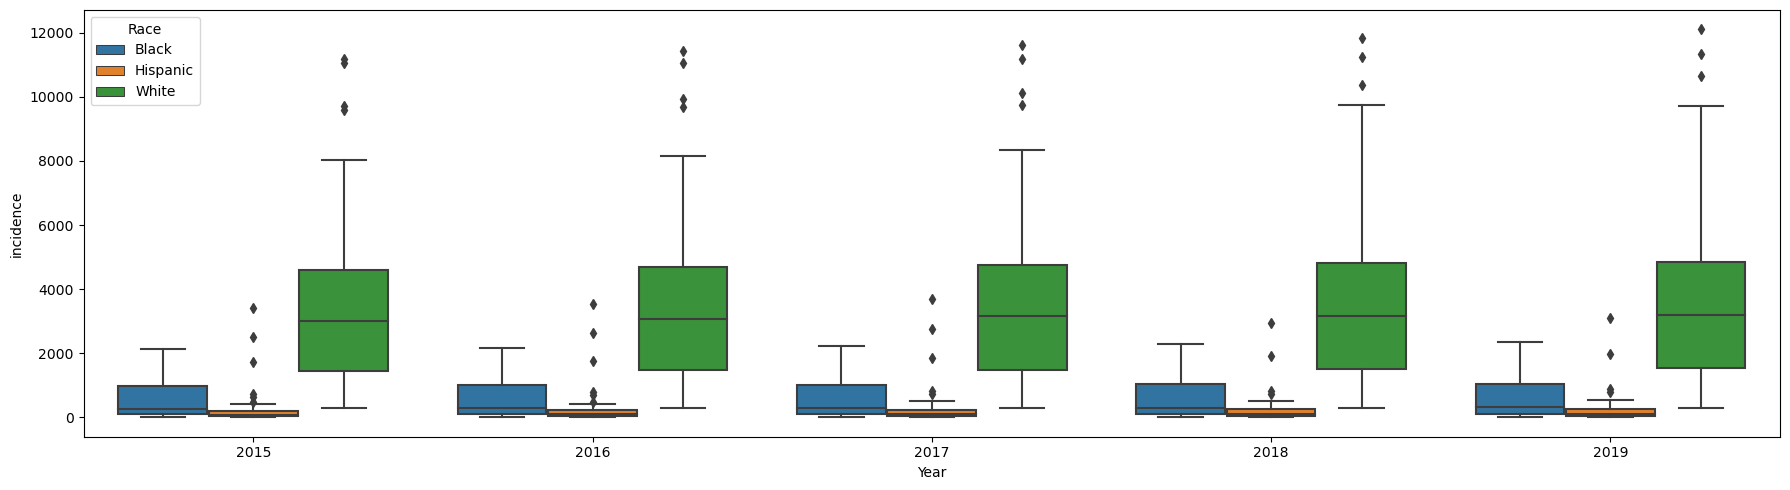

In [113]:
# Set the figure size
plt.rcParams["figure.figsize"] = [18.00, 5.0]
plt.rcParams["figure.autolayout"] = True

# Create a grouped boxplot
sns.boxplot(x=df_com1['Year'], y=df_com1['incidence'], hue=df_com1['Race'])
plt.show()

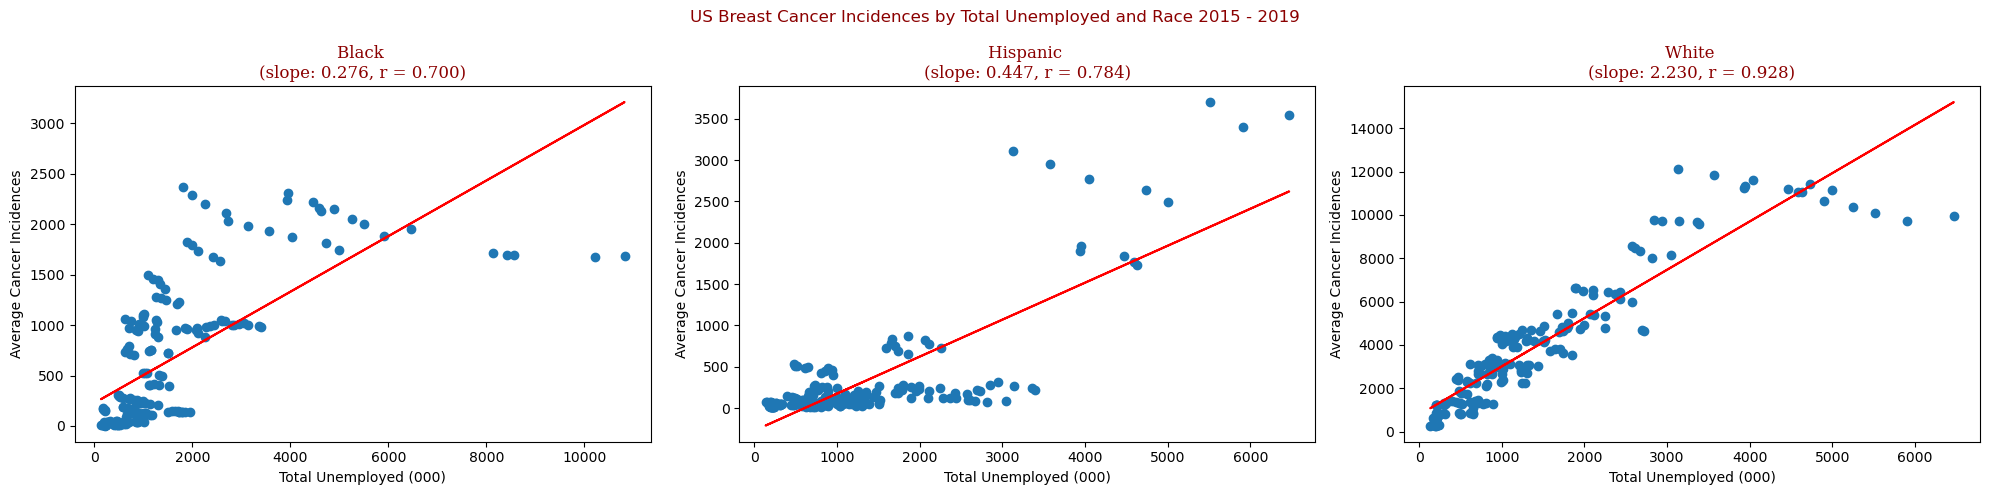

In [114]:
font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=.3, top=.8, bottom=.2)
fig.suptitle(f'US Breast Cancer Incidences by Total Unemployed and Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

for n, race in df_race.iterrows():
    ax = fig.add_subplot(1, 3, n + 1)
    x = df_com1.loc[(df_com1['Race'] == race[0]), 'unemployed (000)'].values
    y = df_com1.loc[(df_com1['Race'] == race[0]), 'incidence'].values
    ax.scatter(x, y)
    lin_reg(np.array(x), np.array(y))
    r, p = st.pearsonr(np.array(x), np.array(y))
    z = np.polyfit(np.array(x), np.array(y), 1)
    ax.set_title(f'{race[0]} \n(slope: {z[0]:.3f}, r = {r:.3f})', fontdict=font)
    ax.set_xlabel('Total Unemployed (000)')
    ax.set_ylabel('Average Cancer Incidences')

In [56]:
filename = 'C:/C_Drive/Bootcamp/ProjectData/output-%s.xlsx' % get_dt()
with pd.ExcelWriter(filename) as writer:
    df_clean.to_excel(writer, sheet_name='data')